<a href="https://colab.research.google.com/github/buchuitoudegou/Note/blob/master/opt_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np

In [16]:
p_x = []
p_y = []
p_std = []

# Maximize Pearson Coefficient
$$r(x,y)=\frac{\Sigma_i(x_i-\bar x)(y_i-\bar y)}{\sqrt{\Sigma_i(x_i-\bar x)^2\Sigma_i(y_i-\bar y)^2}}$$

$$f(x,y)=log(r(x,y))\\argmax_xf(x,y)=argmax_xr(x,y)$$
$$x_{new}=x_{old}+\alpha \nabla_{x} f(x,y)$$


## regularisation
To maximize the pearson coefficient and lower down the standard deviation at the same time.
$$J(x,y)=f(x,y)-\beta\frac{1}{N}\Sigma_i(x_i-\bar x)^2$$
$$x_{new}=x_{old}+\alpha \nabla_{x} J(x,y)$$

In [163]:
from numpy import linalg as LA
def derrivative(x, y, std_norm=0):
  x_hat = np.mean(x)
  y_hat = np.mean(y)
  return (y-y_hat)/np.dot(x-x_hat, y-y_hat) - (x-x_hat)/(LA.norm(x-x_hat))**2 - 2*std_norm/len(x)*(x-x_hat)
def enhance_corr(x, y, round=5000, std_norm=0):
  print(f'origin corr {abs(np.corrcoef(x, y))}, origin stddev: {np.std(x)}')
  x_new = np.copy(x)
  for i in range(round):
    x_new = x_new + 0.0001 * derrivative(x, y, std_norm)
    if i % 10 == 0:
      p_x.append(i)
      p_y.append(abs(np.corrcoef(x_new, y)[0, 1]))
      p_std.append(np.std(x_new))
  print(round, np.corrcoef(x_new, y)[0, 1], np.std(x_new))
  p_x.append(round)
  p_y.append(abs(np.corrcoef(x_new, y)[0, 1]))
  p_std.append(np.std(x_new))
  print('-----------')
  return x_new

In [158]:
x = np.random.rand(100)
y = np.random.rand(100)

origin stddev:  0.3020785413753371
10000 0.7139403978283863 0.38024969358395827
-----------
10000 0.9898827973526662 0.23095104310500386
-----------


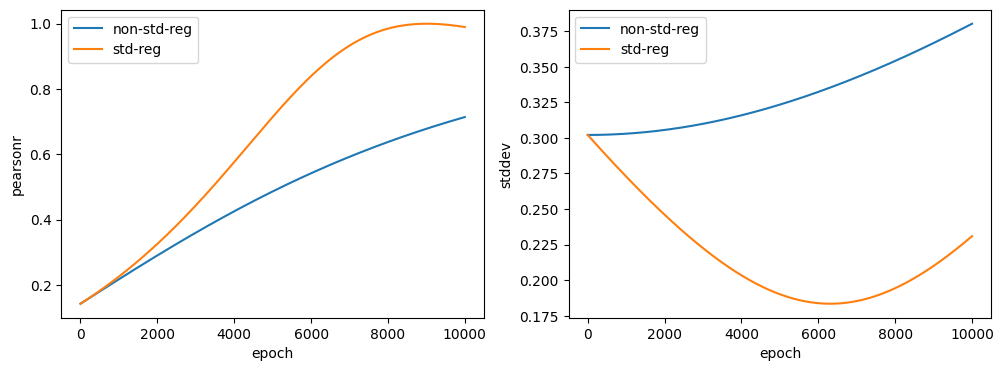

In [164]:
import matplotlib.pyplot as plt
_, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
p_x = []
p_y = []
p_std = []
x_new = enhance_corr(x, y, 10000)
ax1.set_xlabel('epoch')
ax1.set_ylabel('pearsonr')
ax1.plot(p_x, p_y, label='non-std-reg')
ax2.plot(p_x, p_std, label='non-std-reg')
p_x = []
p_y = []
p_std = []
x_std = enhance_corr(x, y, 10000, 50)
ax1.plot(p_x, p_y, label='std-reg')
ax2.plot(p_x, p_std, label='std-reg')
ax2.set_xlabel('epoch')
ax2.set_ylabel('stddev')
ax1.legend()
ax2.legend()
# plt.legend()

In [165]:
def quad_interpolate(x, y):
  arr = []
  for i in range(len(x)):
    arr.append([x[i]**2, x[i], 1])
  A = np.array(arr)
  B = np.array([y[0], y[1], y[2]])
  return np.linalg.solve(A, B)

def predict(a, b, c, x):
  ret = []
  for i in range(len(x)):
    ret.append(a*x[i]**2+b*x[i]+c)
  return np.array(ret)

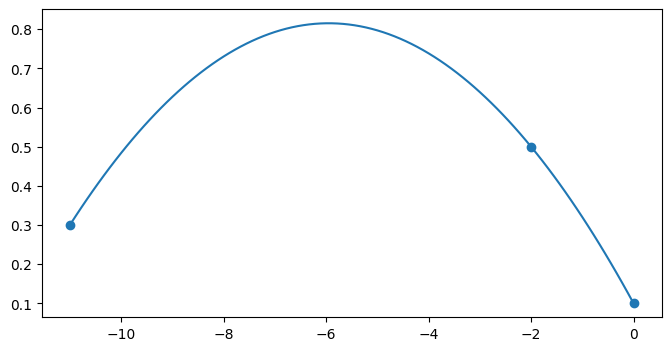

In [166]:
x = np.array([0, -11, -2])
y = np.array([0.1, 0.3, 0.5])
import scipy.interpolate
from scipy.interpolate import interp1d
import numpy as np, matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
xx = np.linspace(x.min(), x.max(), 100)
ax.scatter(x, y)
a,b,c = quad_interpolate(x, y)
ax.plot(xx, predict(a,b,c,xx))
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import csv
import pandas as pd
def enhance_file(infile, outfile, group=None, r=[5000, 1800, 5000, 5000]):
  !rm -f outfile
  df = pd.read_csv(infile)
  if group is not None:
    new_df = []
    for _, row in df.iterrows():
      if group(row.to_numpy()):
        new_df.append(row)
    df = pd.DataFrame(new_df)
  a = []
  f1 = df['feart0'].to_numpy()
  f2 = df['fear1'].to_numpy()
  f3 = df['feart2'].to_numpy()
  stage = df['stage'].to_numpy()
  purchase = df['purchase'].to_numpy()
  quit = df['quit'].to_numpy()
  att = df['attitude'].to_numpy()
  for i in range(len(f1)):
    x = [0, 1, 2]
    a.append(quad_interpolate(x, [f1[i], f2[i], f3[i]])[0])
  a = np.array(a)
  print(a.shape, stage.shape, purchase.shape, quit.shape, att.shape)
  print(np.corrcoef(a, stage)[0, 1], np.corrcoef(a, purchase)[0, 1], np.corrcoef(a, quit)[0, 1], np.corrcoef(a, att)[0, 1])

  stage_new = enhance_coef(stage, a, r[0])
  purchase_new = enhance_coef(purchase, a, r[1])
  quit_new = enhance_coef(quit, a, r[2])
  att_new = enhance_coef(att, a, r[3])

  with open(outfile, 'w+') as f:
    writer = csv.writer(f)
    writer.writerow(['feart0', 'feart1', 'feart2', 'stage', 'purchase', 'quit','attitude'])
    for i in range(len(stage_new)):
      writer.writerow([f1[i], f2[i], f3[i], int(stage_new[i]), int(purchase_new[i]), int(quit_new[i]), int(att_new[i])])

In [ ]:
enhance_file('update 1.csv', 'es.csv', lambda x: x[0]==8, r=[100, 1000, 1000, 300])

(23,) (23,) (23,) (23,) (23,)
0.41140473188512244 -0.5175094299477476 -0.6362940079700922 -0.2866437816019959
0 0.41300560151757426
100 0.56293160089525
-----------
0 -0.5177379291653372
1000 -0.7207667363292314
-----------
0 -0.6364516833498227
1000 -0.7778979130384568
-----------
0 -0.28800993804616215
300 -0.6404145941943429
-----------


In [ ]:
enhance_file('update 1.csv', 'ew.csv', lambda x: x[0]==4, r=[50, 1000, 1000, 300])

(33,) (33,) (33,) (33,) (33,)
0.39110487979396685 -0.442838405104272 -0.2986177779890199 -0.300149862107894
0 0.39312285717266143
50 0.4891177165703287
-----------
0 -0.4430409144738936
1000 -0.6295003081703221
-----------
0 -0.2991460566880059
1000 -0.723482671986943
-----------
0 -0.3009841935331278
300 -0.5324536069329497
-----------


In [ ]:
files.download('es.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('ew.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>